## Loading and Exploring dataset

In [1]:
from google.colab import files
import pandas as pd

!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv

data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2023-06-06 01:10:40--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.1s    

2023-06-06 01:10:41 (91.6 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]



In [2]:
data.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.00,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.00,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...


In [3]:
display(data.shape) # number of row instances and columns
data['relevance'].value_counts()/data.shape[0] # class distributions
# we notice a class imbalance, with 82% of the dataset samples tagged as new not relevant for us economy

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [4]:
# converting class labels into binary: 1 Yes (Relevant), 0 No (Not Relevant). Omit "Not Sure" tag
data = data[data.relevance != "not sure"] # Omitting Not Sure
data.shape
data['relevance'] = data.relevance.map({'yes': 1, 'no': 0})
data = data[["text", "relevance"]]
data.shape


<ipython-input-4-10441e37efb1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['relevance'] = data.relevance.map({'yes': 1, 'no': 0})


(7991, 2)

In [5]:
data.head(3)

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0


## Text Processing
For text processing, we rely on different techniques like tokenization, lowercasing, removing stop words, punctuation, and tags, vectorization. Some advanced techniques are lemmatization and stemming. 

In [6]:
#import preprocess util methods from nltk
import nltk
from nltk.corpus import stopwords

# pre-processing utils
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
stop_words = set(stopwords.words('english'))

# for our custom text processing stage we are removing stopwords, punctuation, and digits
def clean(doc):
  doc = doc.replace("</br>", "")
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = " ".join([token for token in doc.split() if token not in stop_words])
  return doc

## Modeling

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

SEED=32

# train test split
X = data.text
y = data.relevance
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [9]:
# preprocess and vectorize train data

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
# import model classes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train) # dtm stands for document-term matrix
X_test_dtm = vect.transform(X_test)

# notice that the dimension of the vectors is 13811
# 5993 and 1998 is the number of documents we are processing for train and test data
print(X_train_dtm.shape, X_test_dtm.shape)
# X_train_dtm is given in compressed sparse row format (CSR)
# (0, 15689) is the the row and column of the dtm where the presense or frequence 
# of a term is represented with the number 1, 2, 0, etc
# From the shape tuples we notice that we have FEATURE VECTORS WITH OVER 60,000 FEATURES!!!, 
# which is a lot. Sparse feature vectors add noise and are harder to train
print(X_train_dtm[50:51])

(5993, 65193) (1998, 65193)
  (0, 15689)	1
  (0, 43888)	2
  (0, 40695)	2
  (0, 6376)	1
  (0, 14677)	1
  (0, 46558)	2
  (0, 63050)	1
  (0, 41848)	2
  (0, 12382)	1
  (0, 19314)	1
  (0, 25176)	1
  (0, 31434)	1
  (0, 25026)	1
  (0, 33763)	2
  (0, 46662)	1
  (0, 43555)	1
  (0, 22939)	1
  (0, 28150)	1
  (0, 2639)	2
  (0, 16616)	1
  (0, 53880)	1
  (0, 19610)	1
  (0, 44431)	1
  (0, 42294)	3
  (0, 28471)	1
  :	:
  (0, 50434)	1
  (0, 33417)	1
  (0, 25704)	1
  (0, 57916)	1
  (0, 27289)	1
  (0, 39106)	1
  (0, 27977)	1
  (0, 25527)	1
  (0, 23833)	1
  (0, 36237)	1
  (0, 25196)	2
  (0, 35398)	1
  (0, 48367)	1
  (0, 40509)	1
  (0, 38294)	1
  (0, 39856)	1
  (0, 27285)	1
  (0, 23428)	1
  (0, 3424)	1
  (0, 11737)	1
  (0, 13587)	1
  (0, 60369)	1
  (0, 62621)	1
  (0, 37262)	1
  (0, 53949)	1


In [10]:
## Evaluate the classifier using various measures
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# now we can create a classifier, train it, and make predictions for test data
nb = MultinomialNB()

# %time allows to evaluate the training time with this classifier
# and understand the efficiency of the training process with this model, and then 
# compare its efficience with others
%time nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_test_dtm)

CPU times: user 14.7 ms, sys: 801 µs, total: 15.5 ms
Wall time: 31.6 ms


Accuracy:  0.8003003003003003


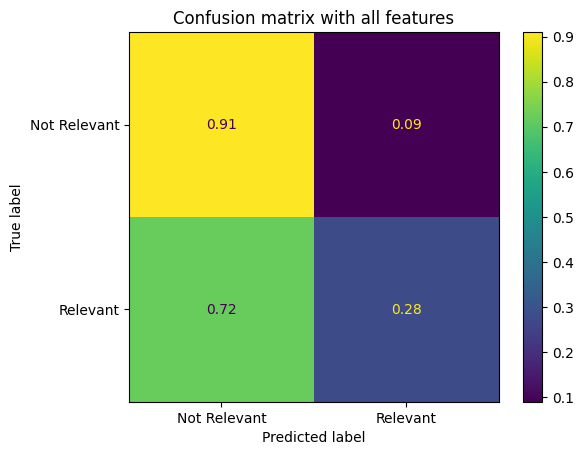

ROC_AOC_Score:  0.7422595170014721


In [11]:
from sklearn.preprocessing import normalize
import numpy as np
import itertools
import matplotlib.pyplot as plt 

print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# creating the Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
normalized_cnf_matrix = np.round(cnf_matrix / cnf_matrix.sum(axis=1, keepdims=True), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cnf_matrix, display_labels=['Not Relevant','Relevant'])
disp.plot()
plt.title("Confusion matrix with all features")
plt.show()

# Calculate AUC to have an idea about the efficiency
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1] #Taking all prediction in position 1 (relevant)
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
# roc_auc is widely used in analysis of binary classification models for predictive performance.
# It is robust to class imbalances
# represents the probability that a random chosen positive instance will be ranked higher than a randomly chosen negative instance by the classifier
# for this case, it evaluates the ability of the model to prioritize relevant new articles over non-relevant

### Improving classification performance
With the previous approach we run into an escenario where the accuracy in predicting relevant cases is very low. Some of the possible reasons are mentioned below:
- Sparse vectors
- Imbalance data (favoring a better predictability in not relevant cases)
- Need of a better algorithm
- Need of a better preprocessing and feature extraction mechanism
- Need to tune classifier's parameters and hyperparameters

First alternative approach, limit the number of features to reduce possible noise

(5993, 5000) (1998, 5000)
CPU times: user 9.09 ms, sys: 0 ns, total: 9.09 ms
Wall time: 19.7 ms
Accuracy:  0.6836836836836837


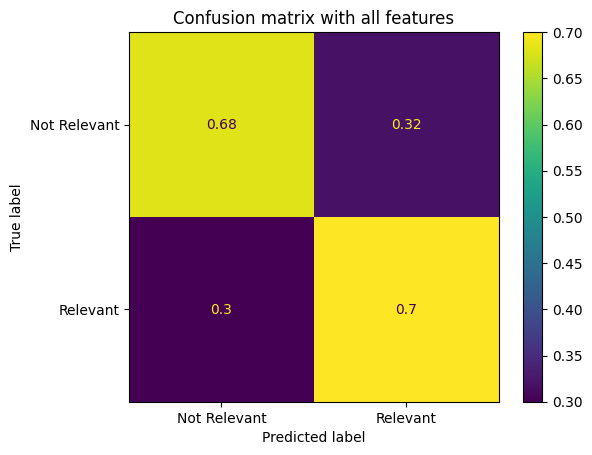

ROC_AOC_Score:  0.7601648166311189


In [12]:
# sparse vectors: Reducing features to 5000
vect = CountVectorizer(preprocessor=clean, max_features=5000)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

print(X_train_dtm.shape, X_test_dtm.shape)

# creating and training new instance of multinomial NB classifier
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

# new accuracy
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# new confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
normalized_cnf_matrix = np.round(cnf_matrix / cnf_matrix.sum(axis=1, keepdims=True), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cnf_matrix, display_labels=['Not Relevant','Relevant'])
disp.plot()
plt.title("Confusion matrix with all features")
plt.show()

# New AUC
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

# Although the efficiency dropped (amount of right predictions over the total amount of predictions), 
# the right relevant and not relevant predictions are balanced. The 'right' approach is based on which 
# variables is the most important in the problem we are trying to solve.

Accuracy:  0.7442442442442443


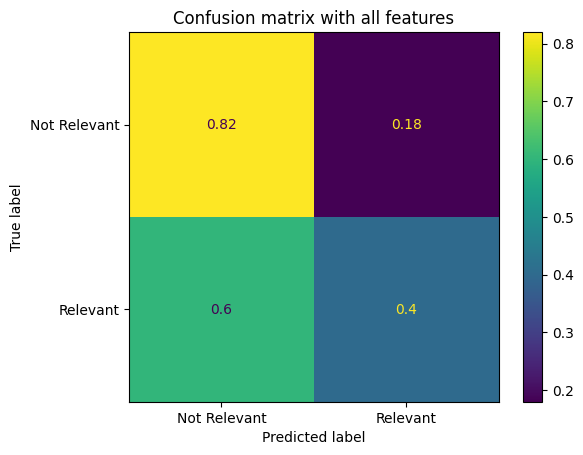

ROC_AOC_Score:  0.682522137288379


In [13]:
# imbalanced data - use of balanced data with logistic regression

vect = CountVectorizer(preprocessor=clean, max_features=5000)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

logreg = LogisticRegression(class_weight="balanced", max_iter=225)
logreg.fit(X_train_dtm, y_train)

y_pred_class = logreg.predict(X_test_dtm)
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# new confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
normalized_cnf_matrix = np.round(cnf_matrix / cnf_matrix.sum(axis=1, keepdims=True), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cnf_matrix, display_labels=['Not Relevant','Relevant'])
disp.plot()
plt.title("Confusion matrix with all features")
plt.show()

# New AUC
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

# Although there was around a 6% increase in accuracy, the correct 
# predictions in the under-represented class got worst. Also, the amount of false positives increased

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy:  0.7332332332332332


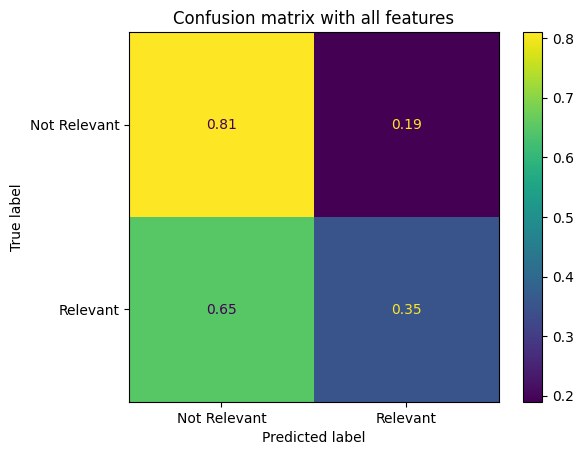

In [14]:
# need of a better algorithm

vect = CountVectorizer(preprocessor=clean, max_features=5000)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

SVM_Classifier = LinearSVC(class_weight="balanced")
SVM_Classifier.fit(X_train_dtm, y_train)

y_pred_class = SVM_Classifier.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# new confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
normalized_cnf_matrix = np.round(cnf_matrix / cnf_matrix.sum(axis=1, keepdims=True), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cnf_matrix, display_labels=['Not Relevant','Relevant'])
disp.plot()
plt.title("Confusion matrix with all features")
plt.show()
